# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [108]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report


def plot_target_distribution(data, targets):

    counts = data[targets].sum()

    plt.figure(figsize=(7, 3))
    counts.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Num instances of targets")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


def reduce_attribute(data, attribute_name, fraction):
    """Reduces the amount of instances of an attribute by a fraction"""
    # Extract attribute column
    atribute_column = data[data[attribute_name] == 1]

    # Remove 50 % of other fualts
    atribute_column_sampled = atribute_column.sample(frac=fraction, random_state=21)

    # Get all classes except other faults
    other_classes = data[data[attribute_name] == 0]

    # Stitch togeather
    data = pd.concat([other_classes, atribute_column_sampled])

    return data


def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size = 1000):
    train_errors, val_errors = [], []
    for m in range(1, len(X_train), step_size):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


# To plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# To print the accuracy of the predictions
def print_accuracy(y_pred, y_test):
    """ Input: Predictions from test set. """
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred, target_names=targets))

## Read The Data
First, we need to take a look at the data structure and attributes.
We want to find correlations that can predict useful information. 

In [3]:
import pandas as pd

CSV_FILENAME = "steel_plate.csv" 
CSV_FOLDER_NAME = "Datasets"
CSV_FILEPATH = os.path.join(CSV_FOLDER_NAME, CSV_FILENAME)

try:
    raw_data = pd.read_csv(CSV_FILEPATH)
except Exception as e:
    print(e)

raw_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


## Explanation of Targets and Features

### Explanation of Steel Plate Faults
The following are descriptions of the different steel plate faults.

- **Pastry**: Small patches or irregularities on the surface of the steel plate, typically caused by imperfections in the manufacturing process or handling during transport. These imperfections affect surface smoothness and appearance.

- **Z_Scratch**: Narrow scratches or marks running **parallel** to the rolling direction. Caused by handling, machining, or contact with abrasive materials during production or transportation.

- **K_Scratch**: Similar to Z-Scratches but run **perpendicular** to the rolling direction. Also caused by handling, machining, or abrasive material contact.

- **Stains**: Discolored or contaminated areas on the surface of the steel plate, often caused by rust, oil, grease, or other foreign substances during processing, storage, or handling.

- **Dirtiness**: Presence of dirt or particulate matter on the surface. This includes various types of debris or contaminants that accumulate during manufacturing, handling, or storage.

- **Bumps**: Raised or protruding areas on the surface, caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transport.

- **Other_Faults**: A broader category encompassing surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

---

## Further Information About the Features

The dataset **Steel Plates Faults** contains **27 features** that describe each fault in detail. Below is an explanation of some key features:

### Location Features
- **X_Minimum**: Minimum x-coordinate of the fault.
- **X_Maximum**: Maximum x-coordinate of the fault.
- **Y_Minimum**: Minimum y-coordinate of the fault.
- **Y_Maximum**: Maximum y-coordinate of the fault.

### Size Features
- **Pixels_Areas**: Area of the fault in pixels.
- **X_Perimeter**: Perimeter along the x-axis of the fault.
- **Y_Perimeter**: Perimeter along the y-axis of the fault.

### Luminosity Features
- **Sum_of_Luminosity**: Sum of luminosity values in the fault area.
- **Minimum_of_Luminosity**: Minimum luminosity value in the fault area.
- **Maximum_of_Luminosity**: Maximum luminosity value in the fault area.

### Material and Index Features
- **TypeOfSteel_A300**: Type of steel (A300).
- **TypeOfSteel_A400**: Type of steel (A400).
- **Steel_Plate_Thickness**: Thickness of the steel plate.
- **Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index**: Various index values related to edges and geometry.

### Logarithmic Features
- **LogOfAreas**: Logarithm of the area of the fault.
- **Log_X_Index, Log_Y_Index**: Logarithmic indices related to X and Y coordinates.

### Statistical Features
- **Orientation_Index**: Index describing orientation.
- **Luminosity_Index**: Index related to luminosity.
- **SigmoidOfAreas**: Sigmoid function applied to areas.

In [156]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [157]:
raw_data.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


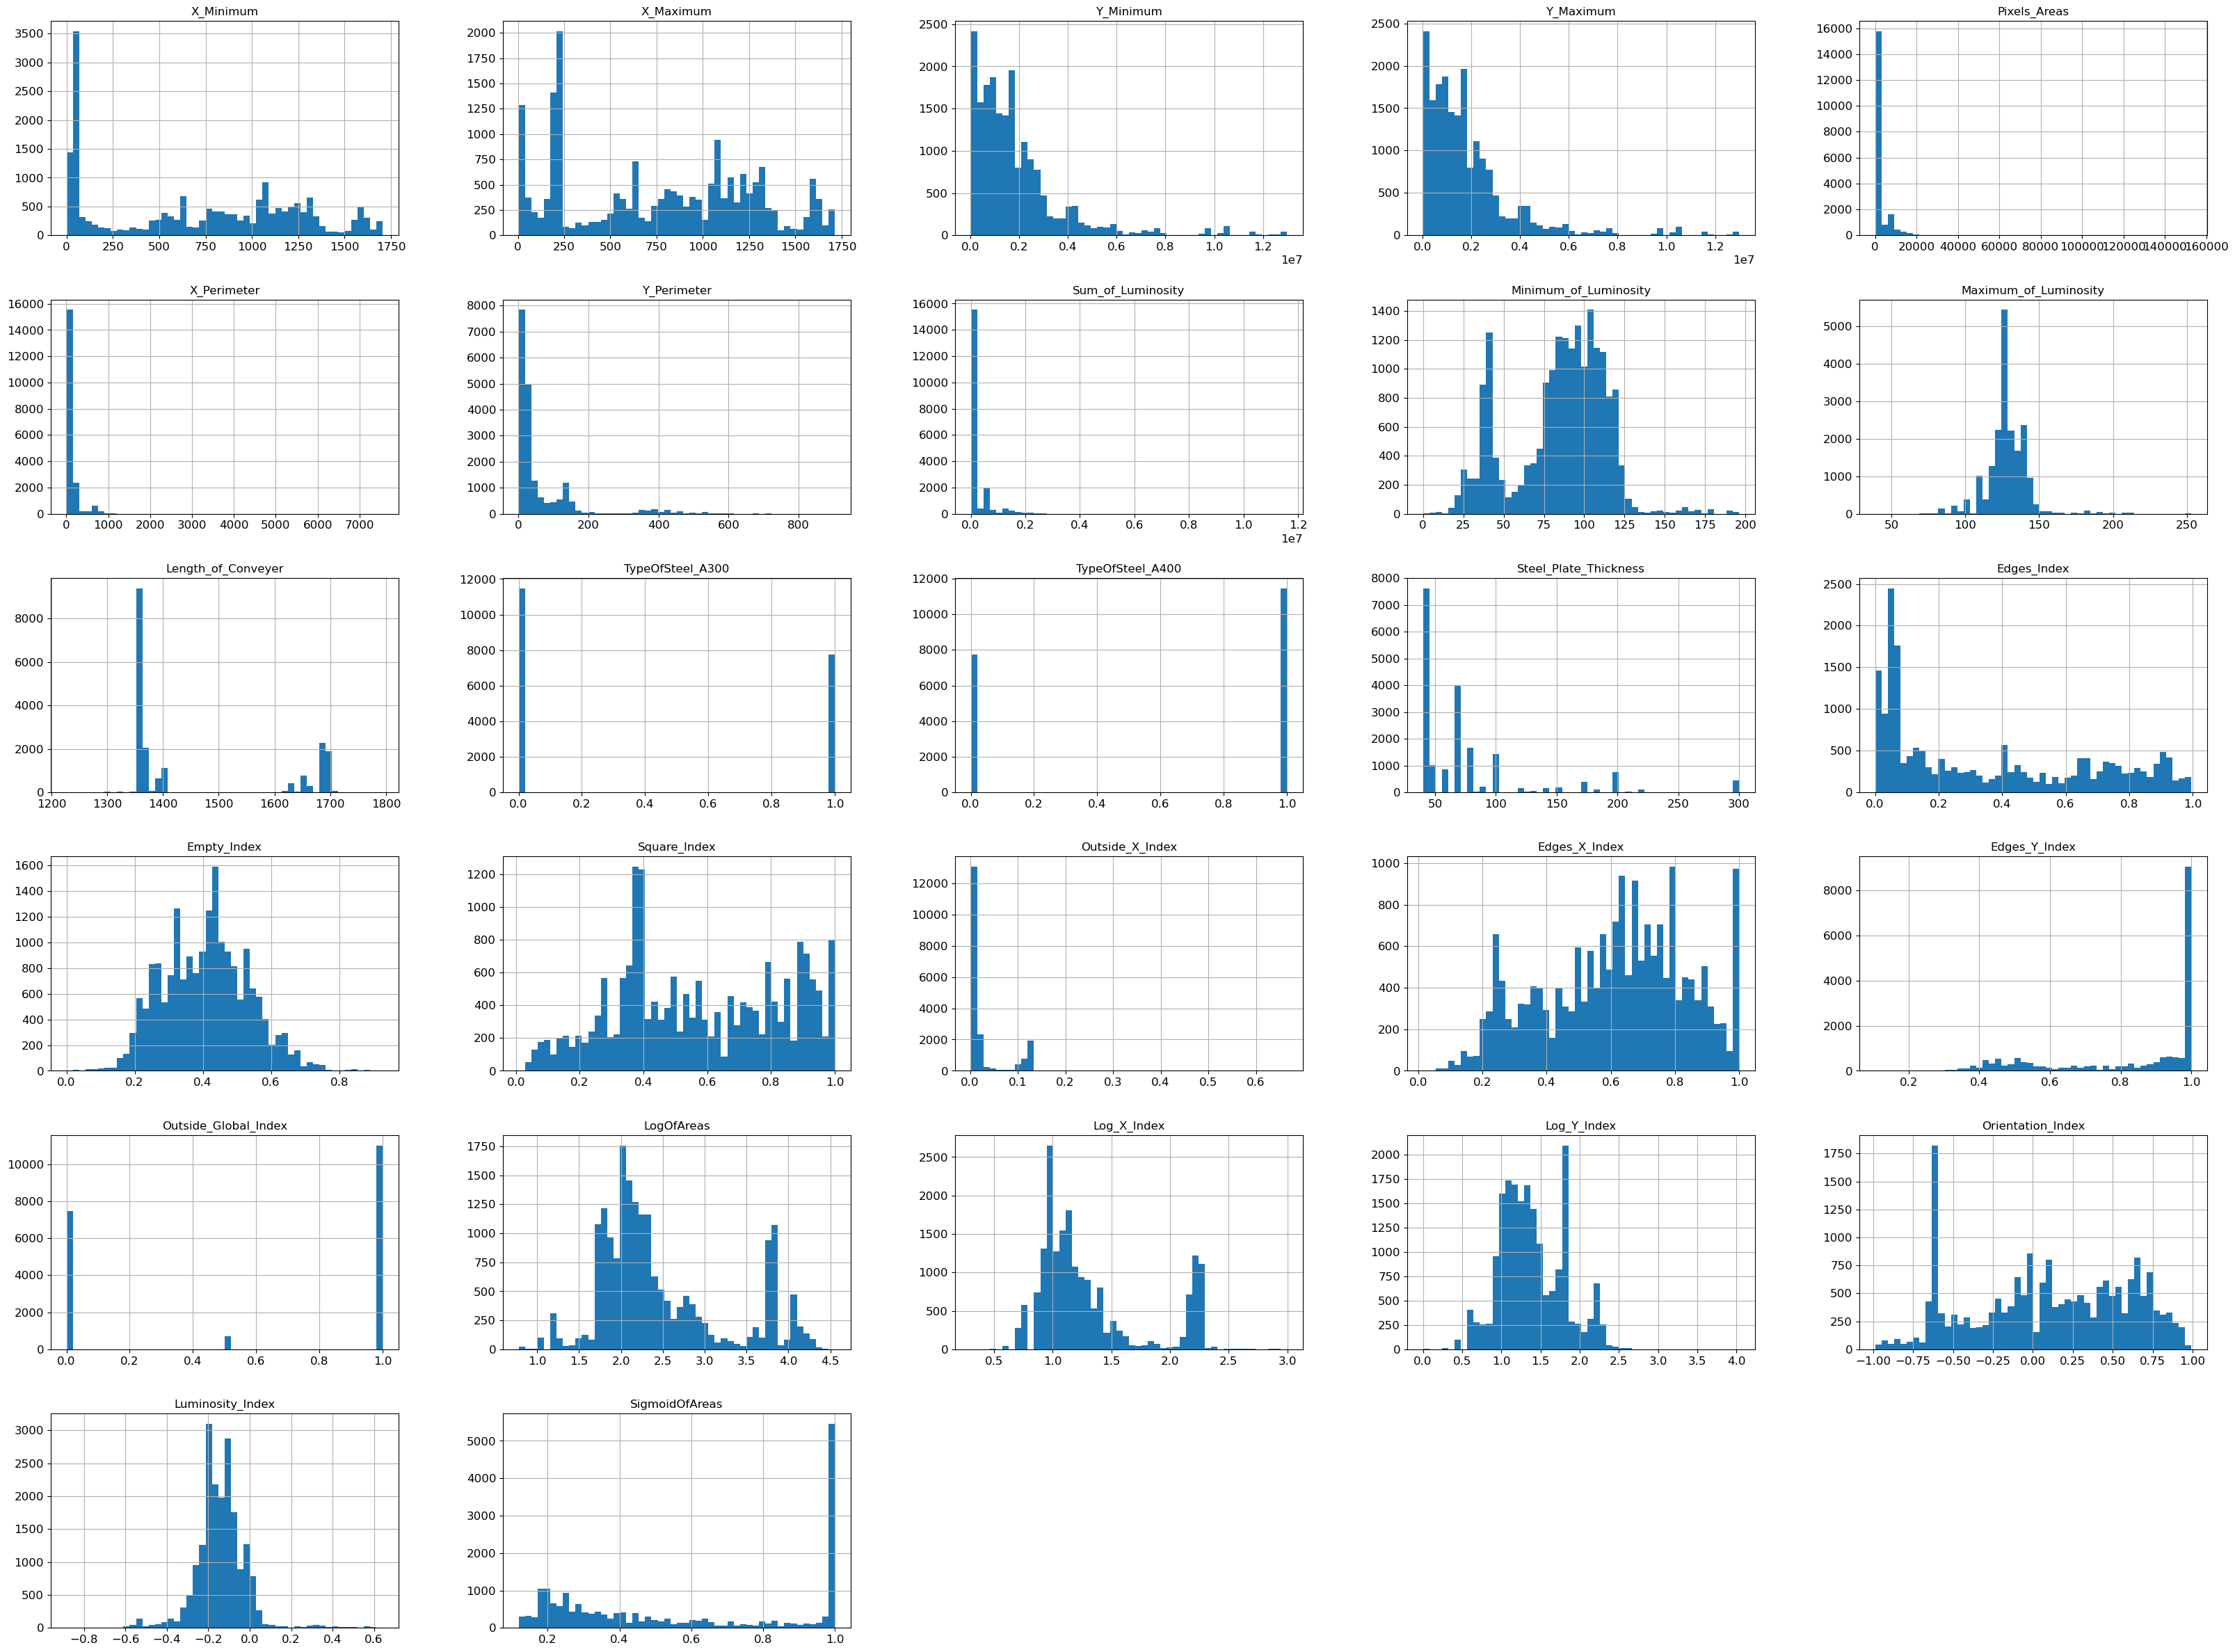

In [158]:
import matplotlib.pyplot as plt

#TODO: Lag et penere plot

selected_atributes = raw_data[["X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas","X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity","Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400","Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index","Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas","Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas"]]
selected_atributes.hist(bins=50, figsize=(40,30))
plt.show()

In [3]:
# Look for NaN values
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


In [4]:
# Drop ID collum
raw_data_drop_id = raw_data.drop(columns=["id"])

In [5]:
# Split into features and target
initial_targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
initial_features = [col for col in raw_data_drop_id.columns if col not in initial_targets]

## Look for corelations

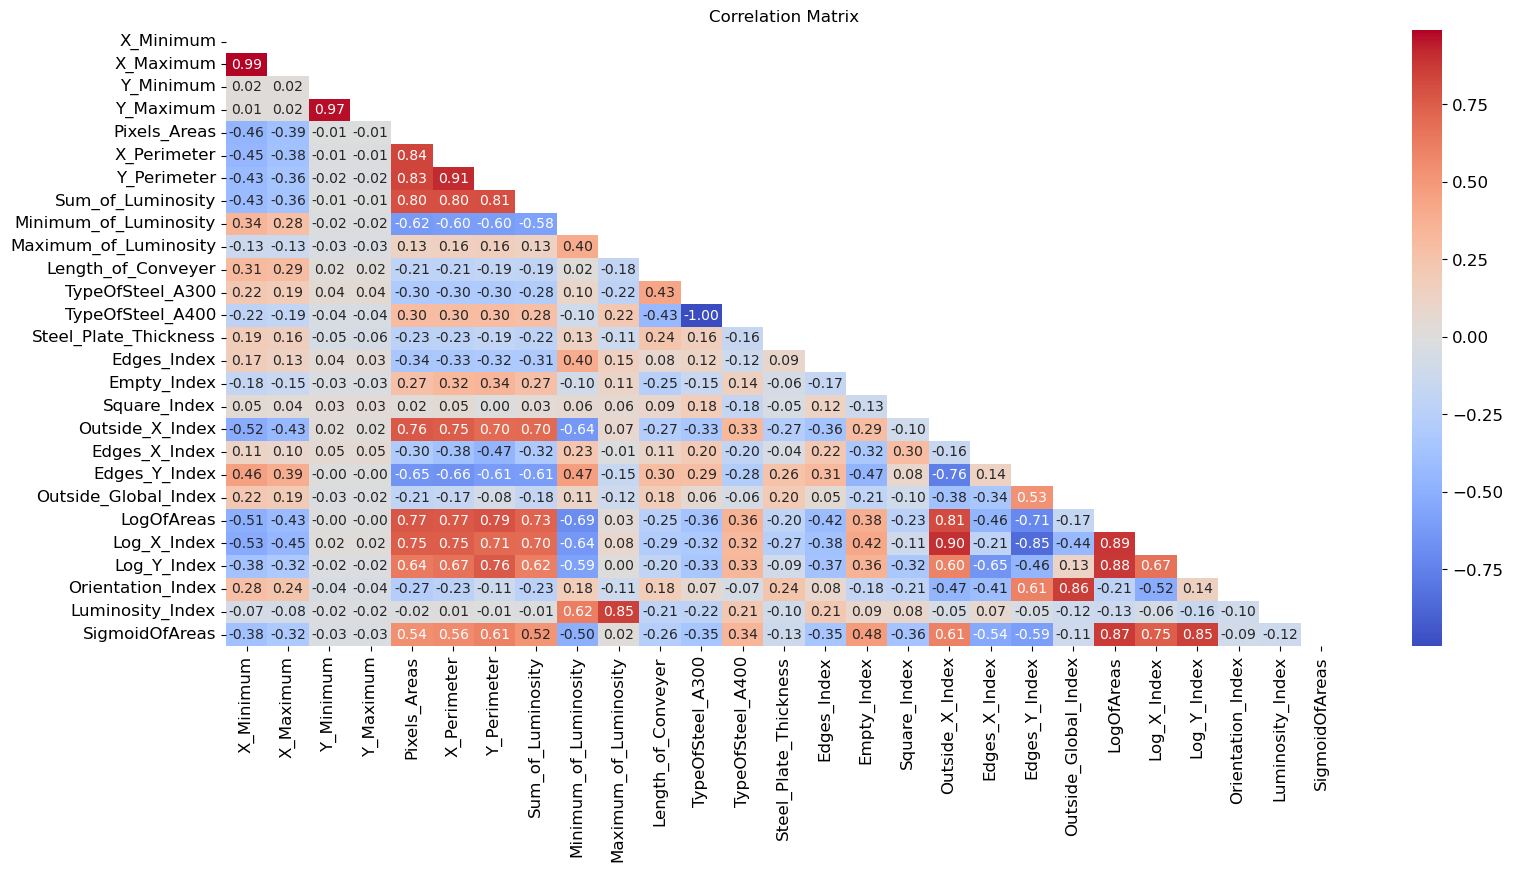

In [6]:
import seaborn as sns

corr = raw_data_drop_id[initial_features].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show() 

### Identifying strongly corrolated data

If the attributes are redundant, remove them. This will help prevent overfitting.

['id', 'TypeOfSteel_A300', 'X_Minimum', 'Y_Minimum', 'X_Perimeter', 'Y_Perimeter', 'LogOfAreas', 'Outside_X_Index', 'Pixels_Areas']

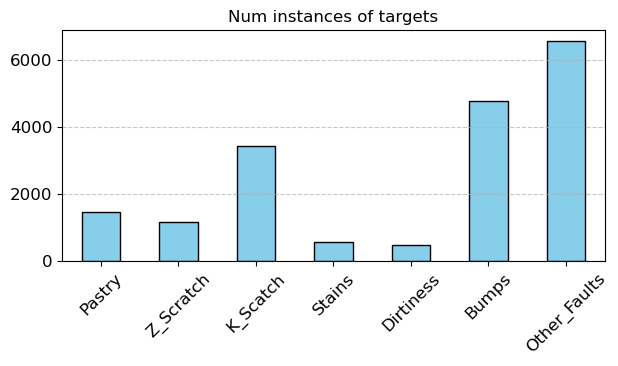

In [ ]:
plot_target_distribution(raw_data, initial_targets)

# **Preparing The Data For Training**

In [70]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class SteelPlateFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_length = True, merge_targets = True, drop_columns = True):
        self.add_length = add_length
        self.merge_targets = merge_targets
        self.drop_columns = drop_columns

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_transformed = X.copy()

        if self.merge_targets:
            # Combine pastry and other faults
            X_transformed["Other_Faults"] += X["Pastry"]
            X_transformed.drop(columns = ["Pastry"], inplace=True)

            # X_transformed["Other_Faults"] += X["Z_Scratch"]
            # X_transformed.drop(columns = ["Z_Scratch"], inplace=True)

            # X_transformed["Other_Faults"] += X["Dirtiness"]
            # X_transformed.drop(columns = ["Dirtiness"], inplace=True)

            # X_transformed["Other_Faults"] += X["K_Scatch"]
            # X_transformed.drop(columns = ["K_Scatch"], inplace=True)

            # X_transformed["Other_Faults"] += X["Stains"]
            # X_transformed.drop(columns = ["Stains"], inplace=True)

            # X_transformed["Other_Faults"] += X["Bumps"]
            # X_transformed.drop(columns = ["Bumps"], inplace=True)


        if self.add_length:
            X_transformed["Length"] = np.sqrt( (X["X_Maximum"] - X["X_Minimum"])**2 + (X["Y_Maximum"] - X["Y_Minimum"])**2 )

        # Drop specified columns
        if self.drop_columns:
            # drop_columns = ["TypeOfSteel_A300", "id", "Outside_Global_Index"]
            # drop_columns = ['id','Square_Index','Sum_of_Luminosity','X_Minimum', 'X_Perimeter', 'SigmoidOfAreas', 'Edges_X_Index', 'Y_Minimum', 'Y_Maximum','TypeOfSteel_A300']
            drop_columns = ['id', 'TypeOfSteel_A300', 'X_Minimum', 'Y_Minimum', 'X_Perimeter', 'Y_Perimeter', 'LogOfAreas', 'Outside_X_Index', 'Pixels_Areas', 'Square_Index', 'Sum_of_Luminosity', 'SigmoidOfAreas', 'Edges_X_Index', 'Outside_Global_Index']
            X_transformed.drop(columns = drop_columns, inplace=True)
        
        return X_transformed

In [71]:
# Add features and remove unnecessary ones
feature_adder = SteelPlateFeatureAdder(add_length = False, 
                                       merge_targets = True, 
                                       drop_columns = True)
data_extra_attribs = feature_adder.transform(raw_data)

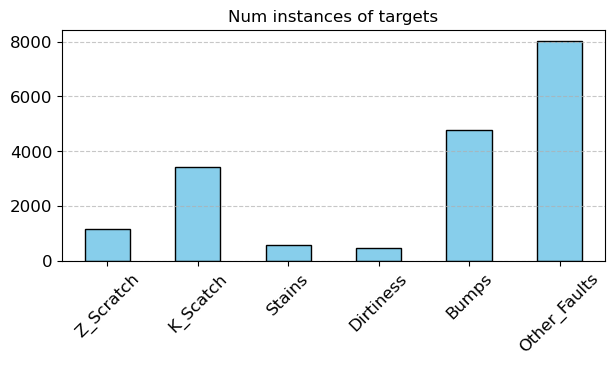

In [72]:
# Update new target and features
targets = [col for col in data_extra_attribs.columns if col in initial_targets]
features = [col for col in data_extra_attribs.columns if col not in targets]

plot_target_distribution(data_extra_attribs, targets)

## Scaling

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the data
exclude_scaling = ["TypeOfSteel_A400", "Edges_Index","Empty_Index","Square_Index","Outside_X_Index","Edges_X_Index","Edges_Y_Index","Outside_Global_Index"] # TODO: finn ut hvilke som ikke skal skaleres
columns_to_scale = [col for col in features if col not in exclude_scaling]

# Remove unnecessary data
scaled_data = data_extra_attribs.copy()
scaled_data[columns_to_scale] = scaler.fit_transform(scaled_data[columns_to_scale])

## Split into train and test

In [74]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(scaled_data)

print(f"Length test set: {len(data_train)} \nLength train set: {len(data_test)}")

# Split into X and y
X_train = data_train[features]
y_train = data_train[targets]

X_test = data_test[features]
y_test = data_test[targets]

Length test set: 14414 
Length train set: 4805


# **Training**

## Random Forrest Classifier

### Grid Search

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [20, 30, 40],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=21)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


* **Run 1:** Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

* **Run 2:** Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


* **Run 3 (excluding several attributes):** Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# random_forrest_clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=21))
random_forrest_clf = RandomForestClassifier(n_estimators=75, max_features='sqrt', max_depth=30, min_samples_split=2, class_weight='balanced', min_samples_leaf=1, random_state=21)

y_train_1d = np.argmax(y_train, axis=1)

random_forrest_clf.fit(X_train, y_train_1d)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=75,
                       random_state=21)

In [127]:
y_pred_rf = random_forrest_clf.predict(X_test)

# Convert to 1d array
y_test_1d = np.argmax(y_test, axis=1)
# y_pred_rf_1d = np.argmax(y_pred_rf, axis=1)

print_accuracy(y_pred_rf, y_test_1d)

Accuracy: 0.638
              precision    recall  f1-score   support

   Z_Scratch       0.64      0.32      0.43       499
    K_Scatch       0.91      0.91      0.91       870
      Stains       0.75      0.83      0.79       146
   Dirtiness       0.61      0.11      0.19       122
       Bumps       0.53      0.40      0.45      1152
Other_Faults       0.58      0.75      0.65      2016

    accuracy                           0.64      4805
   macro avg       0.67      0.55      0.57      4805
weighted avg       0.64      0.64      0.62      4805



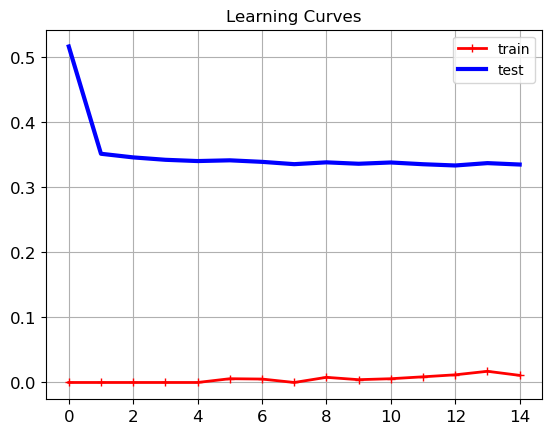

In [102]:
plot_learning_curves(random_forrest_clf, X_train, X_test, y_train, y_test)

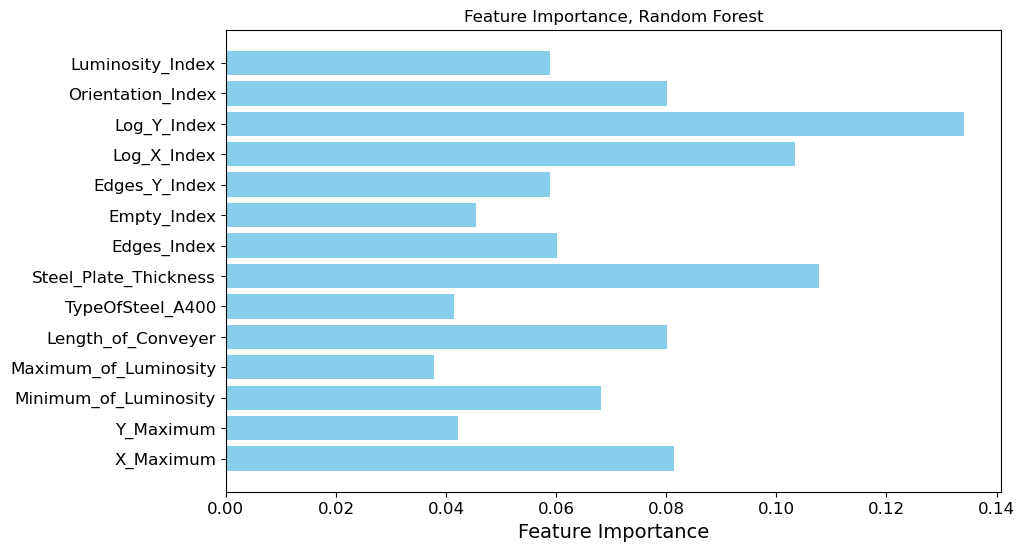

In [109]:
# Feature Importance Plot
importances = random_forrest_clf.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance, Random Forest")
plt.show()

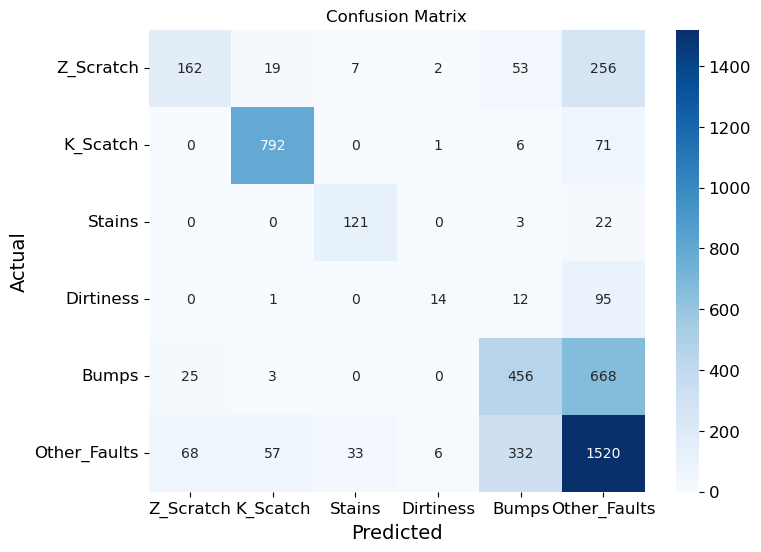

In [112]:
y_test_labels = np.argmax(y_test, axis=1)
# y_pred_labels = np.argmax(y_pred_rf, axis=1)

plot_confusion_matrix(y_test_labels, y_pred_rf, targets)

## Random Forrest One vs All

In [115]:
from sklearn.multiclass import OneVsRestClassifier

# Use the same clasifier as above
random_forrest_clf_OvA = OneVsRestClassifier(random_forrest_clf)
random_forrest_clf_OvA.fit(X_train, y_train_1d)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=30,
                                                     n_estimators=75,
                                                     random_state=21))

In [128]:
y_pred_rfOvA = random_forrest_clf_OvA.predict(X_test)
print_accuracy(y_pred_rfOvA, y_test_1d)

Accuracy: 0.640
              precision    recall  f1-score   support

   Z_Scratch       0.66      0.34      0.45       499
    K_Scatch       0.90      0.91      0.90       870
      Stains       0.74      0.82      0.78       146
   Dirtiness       0.52      0.11      0.19       122
       Bumps       0.53      0.41      0.46      1152
Other_Faults       0.58      0.75      0.66      2016

    accuracy                           0.64      4805
   macro avg       0.66      0.56      0.57      4805
weighted avg       0.64      0.64      0.62      4805



## Gradient Boosting Classifier

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

# Init GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(random_state=21)

# One-vs-All
gb_OvA_clf = OneVsRestClassifier(gradient_boosting_clf)

# Training
gb_OvA_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(random_state=21))

In [ ]:
# Predict
y_pred_gbOvA = gb_OvA_clf.predict(X_test)

print_accuracy(y_pred_gbOvA, y_test)

Accuracy: 0.523
              precision    recall  f1-score   support

   Z_Scratch       0.66      0.51      0.57       301
    K_Scatch       0.91      0.90      0.90       870
      Stains       0.76      0.78      0.77       146
   Dirtiness       0.52      0.12      0.20       122
       Bumps       0.60      0.31      0.41      1152
Other_Faults       0.66      0.53      0.59      2021

   micro avg       0.71      0.54      0.62      4612
   macro avg       0.68      0.53      0.57      4612
weighted avg       0.69      0.54      0.60      4612
 samples avg       0.51      0.52      0.52      4612



c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Stacked Model

In [204]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

base_models = [
    # ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, random_state=20)),
    # ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.05, n_estimators=200, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, random_state=20)),
    # ('catboost', CatBoostClassifier(random_state=20, learning_rate=0.05, n_estimators=200))

    ('rf', RandomForestClassifier(n_estimators=75, max_features='sqrt', max_depth=20, min_samples_split=2, class_weight='balanced', min_samples_leaf=10, random_state=21)),
    ('gb', GradientBoostingClassifier(random_state=21))

]

# Define the final model
final_estimator = LogisticRegression()

# Define the stacking ensemble
stacked_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5))

TRAIN_MODEL = True
if TRAIN_MODEL:
    # Fit the model on the training data
    stacked_model.fit(X_train, y_train)

In [212]:
# Get probabilities
y_pred_proba = stacked_model.predict_proba(X_test)

# Kombiner alle klassesannsynligheter riktig
y_pred_stacked = np.column_stack([arr[:, 1] for arr in y_pred_proba])

# Finn klassen med høyest sannsynlighet
y_pred_labels = np.argmax(y_pred_stacked, axis=1)

# Konverter y_test fra one-hot til klassenumre
y_test_labels = np.argmax(y_test.values, axis=1)

# Evaluer modellen
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Modellens nøyaktighet: {accuracy:.3f}")
print(classification_report(y_test_labels, y_pred_labels))

Modellens nøyaktighet: 0.930
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1015
           1       0.94      0.98      0.96      3790

    accuracy                           0.93      4805
   macro avg       0.92      0.86      0.89      4805
weighted avg       0.93      0.93      0.93      4805



In [122]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Predict on validation data
predictions_val = stacked_model.predict_proba(X_test)

# Beregn AUC for hver klasse
auc_scores = [roc_auc_score(y_test.iloc[:, i], predictions_val[i][:, 1]) for i in range(y_test.shape[1])]
mean_auc = np.mean(auc_scores)
print("Mean AUC Score: ", mean_auc)

Mean AUC Score:  0.945681115515522


# 💣 Mi BOMBOCLAT 